# LangChain-LangGraph 1.x: 构建你的生产级智能体 (Building Your First Agent)

教程将带你了解使用 LangChain 和 LangGraph 构建 Agent（智能体）的核心概念。

**你将学到：**
- 如何与大语言模型 (LLM) 交互
- 如何处理消息 (Messages) 和对话历史
- 如何添加工具 (Tools) 以扩展 LLM 的能力
- 如何构建一个能够推理和行动的 Agent
- 如何添加记忆 (Memory) 以保持上下文
- 如何使用流式传输 (Streaming) 提升用户体验
---
> **注意：** 本教程演示了LangChain1.0 和 LangGraph 1.0 的核心功能。LangGraph 1.0 是构建生产级 Agent 的标准，提供了持久化执行、流式输出、Human-in-the-Loop（人机交互）等原生能力。

# 🚀 LangChain & LangGraph 1.0 迁移完全指南

> **适用对象**：中高级学习者，已有 LangChain 0.x / LangGraph 0.x 使用经验

---

## 📋 目录

1. [LangChain 1.0 主要变化](#langchain-10-主要变化)
2. [LangGraph 1.0 主要变化](#langgraph-10-主要变化)
3. [关键迁移场景](#关键迁移场景)
4. [完整对比表](#完整对比表)
5. [迁移检查清单](#迁移检查清单)

---

## 📦 LangChain 1.0 主要变化

### 1. **`create_agent()` - 新的核心 API**

**变化**：LangChain 1.0 引入了 `create_agent()` 作为构建 Agent 的标准方式，取代了 LangGraph 的 `create_react_agent()`。

```python
# ❌ 旧版 (LangChain 0.x)
from langgraph.prebuilt import create_react_agent
agent = create_react_agent(model, tools)

# ✅ 新版 (LangChain 1.0)
from langchain.agents import create_agent
agent = create_agent(model, tools, system_prompt="...")
```

**迁移要点**：
- 导入路径变化：`langgraph.prebuilt` → `langchain.agents`
- 新增 `system_prompt` 参数替代在消息中手动添加 SystemMessage
- 完全向下兼容 LangGraph 特性（checkpointer、streaming 等）

---

### 2. **Middleware - 可定制化的全新入口**

**变化**：引入中间件机制，提供对 Agent 执行流程的细粒度控制。

**核心 Hooks**：
| Hook | 时机 | 用途 |
|------|------|------|
| `before_agent` | Agent 执行前 | 加载记忆、验证输入 |
| `before_model` | LLM 调用前 | 更新 prompts、裁剪消息 |
| `wrap_model_call` | 围绕 LLM 调用 | 拦截请求/响应、重试、缓存 |
| `wrap_tool_call` | 围绕工具调用 | 拦截工具执行、权限校验 |
| `after_model` | LLM 响应后 | 验证输出、应用守护规则 |
| `after_agent` | Agent 完成后 | 保存结果、清理 |

**示例**：
```python
# ✅ 新版 (LangChain 1.0) - 使用中间件
from langchain.agents import create_agent
from langchain.agents.middleware import PIIMiddleware

agent = create_agent(
    model=model,
    tools=tools,
    middleware=[
        PIIMiddleware("email", strategy="redact", apply_to_input=True)
    ]
)
```

**0.x 替代方案**：在 0.x 版本中需要手动在节点函数中实现这些逻辑，代码分散且难以复用。

---

### 3. **Standard Content Blocks - 统一的内容表示**

**变化**：引入 `content_blocks` 属性，提供跨提供商的统一消息内容访问方式。

```python
# ✅ 新版 (LangChain 1.0) - 统一访问
response = model.invoke("问题")
for block in response.content_blocks:
    if block["type"] == "reasoning":
        print(f"推理: {block['reasoning']}")
    elif block["type"] == "text":
        print(f"回答: {block['text']}")
    elif block["type"] == "tool_call":
        print(f"工具调用: {block['name']}({block['args']})")

# ❌ 旧版 (0.x) - 依赖提供商特定的字段
# 需要针对不同提供商 (OpenAI、Anthropic 等) 写不同的解析代码
```

**支持的内容块类型**：
- `text` - 文本内容
- `reasoning` - 模型推理过程 (如 o1、Claude 的 thinking)
- `tool_call` - 工具调用
- `citation` - 引用信息
- `built_in_tool` - 内置工具 (如 web 搜索、代码解释器)

---

### 4. **简化的命名空间**

**变化**：核心包重构，遗留功能迁移到 `langchain-classic`。

**新的 `langchain` 命名空间**：
```python
# ✅ 新版核心模块
from langchain.agents import create_agent         # Agent 创建
from langchain.messages import HumanMessage        # 消息类型
from langchain.tools import tool                   # 工具装饰器
from langchain.chat_models import init_chat_model  # 模型初始化
from langchain.embeddings import init_embeddings   # 嵌入模型
```

**迁移到 `langchain-classic`**：
```python
# ⚠️ 需要安装 langchain-classic
# pip install langchain-classic

# ❌ 旧位置 → ✅ 新位置
from langchain.chains import LLMChain
from langchain_classic.chains import LLMChain

from langchain.retrievers import MultiQueryRetriever
from langchain_classic.retrievers import MultiQueryRetriever

from langchain import hub
from langchain_classic import hub
```

**为什么这样做？**
- **核心包聚焦**：`langchain` 专注于 Agent 构建的核心抽象
- **向后兼容**：旧功能在 `langchain-classic` 中完全保留
- **性能优化**：减少核心包依赖，加快安装和导入速度

---

### 5. **结构化输出改进**

**变化**：结构化输出现在在主循环内生成，无需额外的 LLM 调用。

```python
# ✅ 新版 (LangChain 1.0)
from langchain.agents import create_agent
from langchain.agents.structured_output import ToolStrategy
from pydantic import BaseModel

class Weather(BaseModel):
    temperature: float
    condition: str

agent = create_agent(
    model,
    tools=[weather_tool],
    response_format=ToolStrategy(Weather)  # 在主循环中生成
)

result = agent.invoke({"messages": [...]})
weather = result["structured_response"]  # Weather(temperature=70.0, condition='sunny')
```

**优势**：
- **成本降低**：无需额外 LLM 调用
- **延迟减少**：减少网络往返
- **灵活策略**：可选择工具调用或提供商原生结构化输出

---

## 📚 参考资源

### 官方文档
- [LangChain 1.0 发布说明](https://docs.langchain.com/oss/python/releases/langchain-v1)
- [LangChain 1.0 迁移指南](https://docs.langchain.com/oss/python/migrate/langchain-v1)

### 深入阅读
- [Middleware 完整指南](https://docs.langchain.com/oss/python/langchain/middleware)
---

**准备好了吗？让我们开始使用 LangChain & LangGraph 1.0 构建生产级 Agent！** 🚀


## 前置部分：环境配置和模型配置

### 创建langchain1.x 环境（在shell中执行）
```
# 创建langchain1.x 环境
conda create -n langchain1.x python=3.10.18 -y

# 确保在 langchain1.x 环境中
conda activate langchain1.x

# 安装 ipykernel
pip install ipykernel -i https://pypi.org/simple

# 将环境注册为 Jupyter 内核
python -m ipykernel install --user --name=langchain1.x --display-name="Python (langchain1.x)"

# 验证内核安装
jupyter kernelspec list
```

### 🔧 环境配置和检查

#### 概述

本教程需要特定的环境配置以确保最佳学习体验。以下配置将帮助你：

- 使用统一的conda环境：激活统一的学习环境
- 通过国内镜像源快速安装依赖：配置pip使用清华镜像源
- 加速模型下载：设置HuggingFace镜像代理
- 检查系统配置：检查硬件和软件配置

#### 配置

- **所需环境及其依赖已经部署好**
- 在`Notebook`右上角选择`jupyter内核`为`python(langchain1.x)`，即可执行下方代码

In [1]:
%%script bash

# 1. 激活 conda 环境 (仅对当前单元格有效)
eval "$(conda shell.bash hook)"
conda activate langchain1.x

echo "========================================="
echo "== Conda 环境检查报告 (仅针对当前 Bash 子进程) =="
echo "========================================="

# 2. 检查当前激活的环境
CURRENT_ENV_NAME=$(basename $CONDA_PREFIX)

if [ "$CURRENT_ENV_NAME" = "langchain1.x" ]; then
    echo "✅ 当前单元格已成功激活到 langchain1.x 环境。"
    echo "✅ 正在使用的环境路径: $CONDA_PREFIX"
    echo ""
    echo "💡 提示: 后续的Python单元格将使用Notebook当前选择的Jupyter内核。"
    echo "   如果需要后续单元格也使用此环境，请执行以下操作:"
    echo "   1. 检查 Notebook 右上角是否已选择 'python(langchain1.x)'。"
else
    echo "❌ 激活失败或环境名称不匹配。当前环境: $CURRENT_ENV_NAME"
    echo ""
    echo "⚠️ 严重提示: 建议将 Notebook 的 Jupyter **内核 (Kernel)** 切换为 'python(langchain1.x)'。"
    echo "   (通常位于 Notebook 右上角或 '内核' 菜单中)"
    echo ""
    echo "📚 备用方法 (不推荐): 如果无法切换内核，则必须在**每个**代码单元格的头部重复以下命令:"
    echo ""
    echo "%%script bash"
    echo "# 必须在每个单元格都执行"
    echo "eval \"\$(conda shell.bash hook)\""
    echo "conda activate langchain1.x"
fi

echo "=========================================" 

== Conda 环境检查报告 (仅针对当前 Bash 子进��) ==
✅ 当前单元格已成功激活到 langchain1.x 环境。
✅ 正在使用的环境路径: /root/miniconda3/envs/langchain1.x

💡 提示: 后续的Python单元格将使用Notebook当前选择的Jupyter内核。
   如果需要后续单元格也使用此环境，请执行以下操作:
   1. 检��� Notebook 右上角是否已选择 'python(langchain1.x)'。


### 🔍 环境信息打印

In [2]:
# 🔍 环境信息检查脚本
#
# 本脚本的作用：
# 1. 安装 pandas 库用于数据表格展示
# 2. 检查系统的各项配置信息
# 3. 生成详细的环境报告表格
#
# 对于初学者来说，这个步骤帮助你：
# - 了解当前运行环境的硬件配置
# - 确认是否满足模型运行的最低要求
# - 学习如何通过代码获取系统信息

# 安装 pandas 库 - 用于创建和展示数据表格
# pandas 是 Python 中最流行的数据处理和分析库
%pip install pandas==2.2.2 tabulate==0.9.0

import platform # 导入 platform 模块以获取系统信息
import os # 导入 os 模块以与操作系统交互
import subprocess # 导入 subprocess 模块以运行外部命令
import pandas as pd # 导入 pandas 模块，通常用于数据处理，这里用于创建表格
import shutil # 导入 shutil 模块以获取磁盘空间信息

# 获取 CPU 信息的函数，包括核心数量
def get_cpu_info():
    cpu_info = "" # 初始化 CPU 信息字符串
    physical_cores = "N/A"
    logical_cores = "N/A"

    if platform.system() == "Windows": # 如果是 Windows 系统
        cpu_info = platform.processor() # 使用 platform.processor() 获取 CPU 信息
        try:
            # 获取 Windows 上的核心数量 (需要 WMI)
            import wmi
            c = wmi.WMI()
            for proc in c.Win32_Processor():
                physical_cores = proc.NumberOfCores
                logical_cores = proc.NumberOfLogicalProcessors
        except:
            pass # 如果 WMI 不可用，忽略错误

    elif platform.system() == "Darwin": # 如果是 macOS 系统
        # 在 macOS 上使用 sysctl 命令获取 CPU 信息和核心数量
        os.environ['PATH'] = os.environ['PATH'] + os.pathsep + '/usr/sbin' # 更新 PATH 环境变量
        try:
            process_brand = subprocess.Popen(['sysctl', "machdep.cpu.brand_string"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout_brand, stderr_brand = process_brand.communicate()
            cpu_info = stdout_brand.decode().split(': ')[1].strip() if stdout_brand else "Could not retrieve CPU info"

            process_physical = subprocess.Popen(['sysctl', "hw.physicalcpu"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout_physical, stderr_physical = process_physical.communicate()
            physical_cores = stdout_physical.decode().split(': ')[1].strip() if stdout_physical else "N/A"

            process_logical = subprocess.Popen(['sysctl', "hw.logicalcpu"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout_logical, stderr_logical = process_logical.communicate()
            logical_cores = stdout_logical.decode().split(': ')[1].strip() if stdout_logical else "N/A"

        except:
            cpu_info = "Could not retrieve CPU info"
            physical_cores = "N/A"
            logical_cores = "N/A"

    else:  # Linux 系统
        try:
            # 在 Linux 上读取 /proc/cpuinfo 文件获取 CPU 信息和核心数量
            with open('/proc/cpuinfo') as f:
                physical_cores_count = 0
                logical_cores_count = 0
                cpu_info_lines = []
                for line in f:
                    if line.startswith('model name'): # 查找以 'model name'开头的行
                        if not cpu_info: # 只获取第一个 model name
                            cpu_info = line.split(': ')[1].strip()
                    elif line.startswith('cpu cores'): # 查找以 'cpu cores' 开头的行
                        physical_cores_count = int(line.split(': ')[1].strip())
                    elif line.startswith('processor'): # 查找以 'processor' 开头的行
                        logical_cores_count += 1
                physical_cores = str(physical_cores_count) if physical_cores_count > 0 else "N/A"
                logical_cores = str(logical_cores_count) if logical_cores_count > 0 else "N/A"
                if not cpu_info:
                     cpu_info = "Could not retrieve CPU info"

        except:
            cpu_info = "Could not retrieve CPU info"
            physical_cores = "N/A"
            logical_cores = "N/A"

    return f"{cpu_info} ({physical_cores} physical cores, {logical_cores} logical cores)" # 返回 CPU 信息和核心数量


# 获取内存信息的函数
def get_memory_info():
    mem_info = "" # 初始化内存信息字符串
    if platform.system() == "Windows":
        # 在 Windows 上不容易通过标准库获取，需要外部库或 PowerShell
        mem_info = "Requires external tools on Windows" # 设置提示信息
    elif platform.system() == "Darwin": # 如果是 macOS 系统
        # 在 macOS 上使用 sysctl 命令获取内存大小
        process = subprocess.Popen(['sysctl', "hw.memsize"], stdout=subprocess.PIPE, stderr=subprocess.PIPE) # 运行 sysctl 命令
        stdout, stderr = process.communicate() # 获取标准输出和标准错误
        mem_bytes = int(stdout.decode().split(': ')[1].strip()) # 解析输出，获取内存大小（字节）
        mem_gb = mem_bytes / (1024**3) # 转换为 GB
        mem_info = f"{mem_gb:.2f} GB" # 格式化输出
    else:  # Linux 系统
        try:
            # 在 Linux 上读取 /proc/meminfo 文件获取内存信息
            with open('/proc/meminfo') as f:
                total_mem_kb = 0
                available_mem_kb = 0
                for line in f:
                    if line.startswith('MemTotal'): # 查找以 'MemTotal' 开头的行
                        total_mem_kb = int(line.split(':')[1].strip().split()[0]) # 解析行，获取总内存（KB）
                    elif line.startswith('MemAvailable'): # 查找以 'MemAvailable' 开头的行
                         available_mem_kb = int(line.split(':')[1].strip().split()[0]) # 解析行，获取可用内存（KB）

                if total_mem_kb > 0:
                    total_mem_gb = total_mem_kb / (1024**2) # 转换为 GB
                    mem_info = f"{total_mem_gb:.2f} GB" # 格式化输出总内存
                    if available_mem_kb > 0:
                        available_mem_gb = available_mem_kb / (1024**2)
                        mem_info += f" (Available: {available_mem_gb:.2f} GB)" # 添加可用内存信息
                else:
                     mem_info = "Could not retrieve memory info" # 如果读取文件出错，设置错误信息

        except:
            mem_info = "Could not retrieve memory info" # 如果读取文件出错，设置错误信息
    return mem_info # 返回内存信息

# 获取 GPU 信息的函数，包括显存
def get_gpu_info():
    try:
        # 尝试使用 nvidia-smi 获取 NVIDIA GPU 信息和显存
        result = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total', '--format=csv,noheader'], capture_output=True, text=True)
        if result.returncode == 0: # 如果命令成功执行
            gpu_lines = result.stdout.strip().split('\n') # 解析输出，获取 GPU 名称和显存
            gpu_info_list = []
            for line in gpu_lines:
                name, memory = line.split(', ')
                gpu_info_list.append(f"{name} ({memory})") # 格式化 GPU 信息
            return ", ".join(gpu_info_list) if gpu_info_list else "NVIDIA GPU found, but info not listed" # 返回 GPU 信息或提示信息
        else:
             # 尝试使用 lshw 获取其他 GPU 信息 (需要安装 lshw)
            try:
                result_lshw = subprocess.run(['lshw', '-C', 'display'], capture_output=True, text=True)
                if result_lshw.returncode == 0: # 如果命令成功执行
                     # 简单解析输出中的 product 名称和显存
                    gpu_info_lines = []
                    current_gpu = {}
                    for line in result_lshw.stdout.splitlines():
                        if 'product:' in line:
                             if current_gpu:
                                 gpu_info_lines.append(f"{current_gpu.get('product', 'GPU')} ({current_gpu.get('memory', 'N/A')})")
                             current_gpu = {'product': line.split('product:')[1].strip()}
                        elif 'size:' in line and 'memory' in line:
                             current_gpu['memory'] = line.split('size:')[1].strip()

                    if current_gpu: # 添加最后一个 GPU 的信息
                        gpu_info_lines.append(f"{current_gpu.get('product', 'GPU')} ({current_gpu.get('memory', 'N/A')})")

                    return ", ".join(gpu_info_lines) if gpu_info_lines else "GPU found (via lshw), but info not parsed" # 如果找到 GPU 但信息无法解析，设置提示信息
                else:
                    return "No GPU found (checked nvidia-smi and lshw)" # 如果两个命令都找不到 GPU，设置提示信息
            except FileNotFoundError:
                 return "No GPU found (checked nvidia-smi, lshw not found)" # 如果找不到 lshw 命令，设置提示信息
    except FileNotFoundError:
        return "No GPU found (nvidia-smi not found)" # 如果找不到 nvidia-smi 命令，设置提示信息


# 获取 CUDA 版本的函数
def get_cuda_version():
    try:
        # 尝试使用 nvcc --version 获取 CUDA 版本
        result = subprocess.run(['nvcc', '--version'], capture_output=True, text=True)
        if result.returncode == 0: # 如果命令成功执行
            for line in result.stdout.splitlines():
                if 'release' in line: # 查找包含 'release' 的行
                    return line.split('release ')[1].split(',')[0] # 解析行，提取版本号
        return "CUDA not found or version not parsed" # 如果找不到 CUDA 或版本无法解析，设置提示信息
    except FileNotFoundError:
        return "CUDA not found" # 如果找不到 nvcc 命令，设置提示信息

# 获取 Python 版本的函数
def get_python_version():
    return platform.python_version() # 获取 Python 版本

# 获取 Conda 版本的函数
def get_conda_version():
    try:
        # 尝试使用 conda --version 获取 Conda 版本
        result = subprocess.run(['conda', '--version'], capture_output=True, text=True)
        if result.returncode == 0: # 如果命令成功执行
            return result.stdout.strip() # 返回 Conda 版本
        return "Conda not found or version not parsed" # 如果找不到 Conda 或版本无法解析，设置提示信息
    except FileNotFoundError:
        return "Conda not found" # 如果找不到 conda 命令，设置提示信息

# 获取物理磁盘空间信息的函数
def get_disk_space():
    try:
        total, used, free = shutil.disk_usage("/") # 获取根目录的磁盘使用情况
        total_gb = total / (1024**3) # 转换为 GB
        used_gb = used / (1024**3) # 转换为 GB
        free_gb = free / (1024**3) # 转换为 GB
        return f"Total: {total_gb:.2f} GB, Used: {used_gb:.2f} GB, Free: {free_gb:.2f} GB" # 格式化输出
    except Exception as e:
        return f"Could not retrieve disk info: {e}" # 如果获取信息出错，设置错误信息

# 获取环境信息
os_name = platform.system() # 获取操作系统名称
os_version = platform.release() # 获取操作系统版本
if os_name == "Linux":
    try:
        # 在 Linux 上尝试获取发行版和版本
        lsb_info = subprocess.run(['lsb_release', '-a'], capture_output=True, text=True)
        if lsb_info.returncode == 0: # 如果命令成功执行
            for line in lsb_info.stdout.splitlines():
                if 'Description:' in line: # 查找包含 'Description:' 的行
                    os_version = line.split('Description:')[1].strip() # 提取描述信息作为版本
                    break # 找到后退出循环
                elif 'Release:' in line: # 查找包含 'Release:' 的行
                     os_version = line.split('Release:')[1].strip() # 提取版本号
                     # 尝试获取 codename
                     try:
                         codename_info = subprocess.run(['lsb_release', '-c'], capture_output=True, text=True)
                         if codename_info.returncode == 0:
                             os_version += f" ({codename_info.stdout.split(':')[1].strip()})" # 将 codename 添加到版本信息中
                     except:
                         pass # 如果获取 codename 失败则忽略

    except FileNotFoundError:
        pass # lsb_release 可能未安装，忽略错误

full_os_info = f"{os_name} {os_version}" # 组合完整的操作系统信息
cpu_info = get_cpu_info() # 调用函数获取 CPU 信息和核心数量
memory_info = get_memory_info() # 调用函数获取内存信息
gpu_info = get_gpu_info() # 调用函数获取 GPU 信息和显存
cuda_version = get_cuda_version() # 调用函数获取 CUDA 版本
python_version = get_python_version() # 调用函数获取 Python 版本
conda_version = get_conda_version() # 调用函数获取 Conda 版本
disk_info = get_disk_space() # 调用函数获取物理磁盘空间信息


# 创建用于存储数据的字典
env_data = {
    "项目": [ # 项目名称列表
        "操作系统",
        "CPU 信息",
        "内存信息",
        "GPU 信息",
        "CUDA 信息",
        "Python 版本",
        "Conda 版本",
        "物理磁盘空间" # 添加物理磁盘空间
    ],
    "信息": [ # 对应的信息列表
        full_os_info,
        cpu_info,
        memory_info,
        gpu_info,
        cuda_version,
        python_version,
        conda_version,
        disk_info # 添加物理磁盘空间信息
    ]
}

# 创建一个 pandas DataFrame
df = pd.DataFrame(env_data)

# 打印表格
print("### 环境信息") # 打印标题
print(df.to_markdown(index=False)) # 将 DataFrame 转换为 Markdown 格式并打印，不包含索引


Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.
### 环境信息
| 项目         | 信息                                                                               |
|:-------------|:-----------------------------------------------------------------------------------|
| 操作系统     | Linux Ubuntu 22.04.4 LTS                                                           |
| CPU 信息     | 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz (1 physical cores, 4 logical cores) |
| 内存信息     | 5.75 GB (Available: 4.82 GB)                                                       |
| GPU 信息     | No GPU found (nvidia-smi not found)                                                |
| CUDA 信息    | CUDA not found                                                                     |
| Python 版本  | 3.10.18                                                                            |
| Conda 版本   | conda 24.4.0                                         

## 第 0 部分: 设置与安装

首先，我们需要安装必要的 Python 包并设置环境。

In [3]:
# 安装所需的包
!pip install langchain==1.1.3 \
langchain-openai==1.1.1 \
python-dotenv==1.2.1 \
langgraph==1.0.4 \
sqlalchemy==2.0.44 \
requests==2.32.5

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


### 配置模型

In [4]:
# 导入必要的模块
import os, getpass

def _set_env(var: str):
    """
    设置环境变量的辅助函数
    如果环境变量不存在，则提示用户输入
    """
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

# 设置 OpenAI API 密钥 
# 这是使用 OpenAI 模型所必需的
_set_env("OPENAI_API_KEY")
# 设置 OpenAI API代理地址 (例如：https://api.apiyi.com/v1）
_set_env("OPENAI_BASE_URL")

In [5]:
"""
模型初始化文件

此文件配置应用程序中使用的 LLM (大语言模型)。

默认配置:
- 默认提供商是 OpenAI (使用 o3-mini 模型)
- 你也可以通过取消注释相应的行来切换到 Anthropic

备选提供商:
要使用不同的 LLM 提供商，请按照以下步骤操作:
1. 注释掉下方的 "Default Models" (默认模型) 部分
2. 取消注释你想要的提供商部分:
   - Azure OpenAI: 需要设置 AZURE_OPENAI_API_KEY 和 AZURE_OPENAI_ENDPOINT
   - AWS Bedrock: 需要设置 AWS 凭证和配置
   - Google Vertex AI: 需要设置 GOOGLE_APPLICATION_CREDENTIALS
3. 按照每个部分内的设置说明进行操作
"""

# """默认模型 (Default Models)"""
from langchain.chat_models import init_chat_model
# 初始化聊天模型，这里使用 OpenAI 的 o3-mini
model = init_chat_model("openai:o3-mini")

# 使用 Anthropic 替代 OpenAI
# model = init_chat_model("anthropic:claude-haiku-4-5")


# """AZURE OpenAI Version"""
# from langchain_openai import AzureChatOpenAI
# # from langchain_anthropic import ChatAnthropic
# # from langchain_google_vertexai import ChatVertexAI
# from azure.identity import InteractiveBrowserCredential

# credential = InteractiveBrowserCredential()

# def get_token():
#     token = credential.get_token("https://cognitiveservices.azure.com/.default")
#     return token.token

# For AzureOpenAI, make sure you set AZURE_OPENAI_API_KEY and AZURE_OPENAI_ENDPOINT

# Azure OpenAI: Using Environment Variables
# AZURE_OPENAI_GPT_4O = AzureChatOpenAI(
#     azure_deployment="gpt-4o",
#     streaming=True
# )

# Azure OpenAI: Using Azure AD
# AZURE_OPENAI_GPT_4O = AzureChatOpenAI(
#     api_version="2024-03-01-preview",
#     azure_endpoint="https://deployment.openai.azure.com/",
#     azure_deployment="gpt-4o",
#     azure_ad_token_provider=get_token
# )


# """Bedrock Version"""
# from dotenv import load_dotenv
# from langchain_aws import ChatBedrockConverse
# import os

# load_dotenv(dotenv_path="../../.env", override=True)

# AWS_ACCESS_KEY_ID=os.getenv("AWS_ACCESS_KEY_ID")
# AWS_SECRET_ACCESS_KEY=os.getenv("AWS_SECRET_ACCESS_KEY")
# AWS_REGION_NAME=os.getenv("AWS_REGION_NAME")
# AWS_MODEL_ARN=os.getenv("AWS_MODEL_ARN")

# model = ChatBedrockConverse(
#     aws_access_key_id=AWS_ACCESS_KEY_ID,
#     aws_secret_access_key=AWS_SECRET_ACCESS_KEY, 
#     region_name=AWS_REGION_NAME,
#     provider="anthropic",
#     model_id=AWS_MODEL_ARN
# )


# """Google Vertex AI version"""
# Make sure you have your vertex ai credentials setup and your GOOGLE_APPLICATION_CREDENTIALS are pointing to the JSON file. 

# import os
# from pathlib import Path
# from dotenv import load_dotenv
# from langchain.chat_models import init_chat_model

# # Find project root and load .env
# # Use __file__ to get the location of this file, then go up two directories to project root
# project_root = Path.cwd().parent.parent
# load_dotenv(dotenv_path=project_root / ".env", override=True)

# # Fix credentials path to absolute
# if "GOOGLE_APPLICATION_CREDENTIALS" in os.environ:
#     cred_path = os.environ["GOOGLE_APPLICATION_CREDENTIALS"]
#     if not os.path.isabs(cred_path):
#         os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = str(project_root / cred_path.lstrip("./"))

# # Create model
# model = init_chat_model("google_vertexai:gemini-2.5-flash")


### 常用方法配置

In [6]:
# 忽略 LangSmith 使用 UUID v7 的警告（在简单的无线程 ID 示例中）
import warnings
warnings.filterwarnings('ignore', message='LangSmith now uses UUID v7')

### 初始化你的 LLM

## 第 1 部分: 你的第一次 LLM 调用

LangChain 提供了一个 **标准模型接口**，通过这个接口，你可以轻松地在 OpenAI、Anthropic、Google 等不同的模型提供商之间切换，而无需更改业务代码。

让我们从初始化一个聊天模型开始。

In [7]:
# 进行第一次调用！
# .invoke() 是同步调用的标准方法，发送输入并等待返回结果
response = model.invoke("LangChain 是什么？")
response.pretty_print()

================================== Ai Message ==================================

LangChain 是一个开源框架，旨在帮助开发者构建基于大语言模型（LLMs）的应用程序。它的核心理念是将语言模型与其他工具和数据源结合起来，通过构建“链”（chain）的方式实现多步推理、决策和交互。例如，LangChain 可以将语言模型与数据库、API 调用、文件系统或其他外部工具衔接，从而实现更复杂和动态的应用场景，如问答系统、聊天机器人、自动化工作流等。

主要特点包括：
1. 模块化设计：允许开发者灵活组合不同组件（例如语言模型、提示模板、工具），快速构建应用。
2. 多步推理支持：通过构建处理链，将简单的语言模型输出逐步转化为解决复杂问题的方案。
3. 扩展性：易于与不同的数据源和业务逻辑集成，支持定制化开发满足多样化需求。

总之，LangChain 为利用大语言模型构建具有复杂逻辑和交互能力的应用提供了高效、灵活的平台。


### 核心要点：
- `init_chat_model()` (或类似工厂方法) 提供了跨 LLM 提供商的统一接口
- `.invoke()` 方法发送消息并返回响应
- 没有通过代码绑定特定厂商——可以轻松更换模型！

## 第 2 部分: 理解消息 (Messages)

**消息 (Messages)** 是 LangChain 中模型上下文的基本单元。它们代表了模型的输入和输出，携带了内容 (context) 和元数据 (metadata)。

主要有几种消息类型：
- **SystemMessage** - 系统消息，用于设定模型的行为准则或角色
- **HumanMessage** - 用户输入，即人类说的话
- **AIMessage** - 模型回复，即 AI 说的话
- **ToolMessage** - 工具执行的结果

In [8]:
from langchain.messages import HumanMessage, SystemMessage, AIMessage

# 创建一个包含不同消息类型的对话列表
messages = [
    SystemMessage(content="你是一个乐于助人的 AI 助手，能够用简单易懂的语言解释技术概念。"), # 设定 AI 角色
    HumanMessage(content="什么是智能体 (Agent)？"), # 用户提问
]

# 调用模型
response = model.invoke(messages)
response.pretty_print()

================================== Ai Message ==================================

智能体（Agent）是指一个能够感知周围环境，并根据感知到的信息做出决策和采取行动的实体。换句话说，智能体可以接收外界的输入（比如传感器数据或信息），经过处理后执行某些动作以达到预定目标。

举个例子：  
1. 自动驾驶汽车可以看作一种智能体。它通过摄像头、雷达等感知道路情况，经过算法处理后，做出加速、刹车或转向等决策，从而安全地行驶。  
2. 在软件系统中，聊天机器人也是一种智能体。它接收到用户的信息后，经过自然语言处理后，生成合适的回答，与用户进行交互。

智能体可以用于各种领域，如机器人技术、人工智能、自动化系统等。它们可以是简单的规则系统，也可以结合学习算法和推理能力，成为更为复杂和智能的系统。


### 多轮对话

通过维护消息列表，可以轻松实现多轮对话历史管理：

In [9]:
# 继续对话
messages.append(response)  # 将 AI 的上一次回复添加到历史中
messages.append(HumanMessage(content="能给我举个例子吗？")) # 添加新的用户提问

# 再次调用模型，这次带上了完整的上下文
response = model.invoke(messages)
response.pretty_print()

================================== Ai Message ==================================

让我们以家用扫地机器人为例来说明智能体的概念。

想象一下扫地机器人的工作过程：  
1. 感知环境：扫地机器人通过内置的传感器（例如红外传感器或激光雷达）来探测周围的墙壁、家具和其他障碍物。  
2. 决策：根据所收集的信息，机器人会判断哪里有障碍物，以及哪些区域还没有清扫，从而决定下一步的行进路线。  
3. 执行动作：一旦确定了路线，它就会启动电机，沿着选定的路径前进，并调整自己的方向来避免碰撞，同时不断清扫地面。

在这个例子中，扫地机器人就相当于一个智能体，因为它具备以下特点：  
- 能够感知环境（通过传感器感知障碍物和空间分布）。  
- 能够处理信息并做出决策（比如选择路径、避开障碍）。  
- 能够采取行动来完成任务（即清扫地面）。  

这样的设计使得机器人看起来很“聪明”，可以在无需人类手动控制的情况下自动完成任务。


### 核心要点：
- Messages (消息) 构成了对话历史
- SystemMessage 设定了模型的行为基调
- 通过向列表追加 (append) 消息来构建多轮对话

## 第 3 部分: 添加工具 - 扩展 LLM 能力

LLM 擅长处理语言，但它们无法访问外部数据或执行动作。**Tools (工具)** 扩展了它们的能力。你可以给 LLM 提供一个工具列表，当它需要时，它会指定要调用哪个工具。你的工作是执行这些工具，并将结果反馈给 LLM，以便它决定下一步做什么。

你可以通过编写一个带有清晰描述的 Python 函数来创建一个工具。LangChain 的 `@tool` 装饰器会自动处理函数信息的格式化，使其符合 LLM 的要求。

让我们创建一些简单的工具：

In [10]:
import requests
import json

from langchain_core.tools import tool


# 一个基本的硬编码工具
@tool
def search_movies(genre: str) -> str:
    """根据类型搜索电影推荐。""" # 函数的 docstring 会作为工具描述提供给 LLM
    # 在真实应用中，这可能会查询电影数据库
    movies = {
    "科幻": "沙丘, 星际穿越, 银翼杀手2049",
    "喜剧": "布达佩斯大饭店, 超级坏, 利刃出鞘",
    "动作": "疯狂的麦克斯：狂暴之路, 疾速追杀, 碟中谍"
    }
    return movies.get(genre.lower(), "No movies found for that genre")

# 一个更真实的工具，调用外部 API
@tool
def get_weather(latitude: float, longitude: float) -> str:
    """获取指定坐标的当前温度 (华氏度) 和天气代码。

    Args:
        latitude: 纬度坐标
        longitude: 经度坐标

    Returns:
        包含 temperature_fahrenheit 和 weather_code 的 JSON 字符串 (不包含代码解释，留给模型处理)
    """
    url = "https://api.open-meteo.com/v1/forecast"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "current": "temperature_2m,weather_code",
        "temperature_unit": "celsius"
    }

    weather = requests.get(url, params=params).json()["current"]
    temperature = weather["temperature_2m"]
    weather_code = weather["weather_code"]
    result = {
        "temperature_celsius": temperature,
        "weather_code": weather_code
    }

    return json.dumps(result)



# 直接测试工具，例如查询旧金山的坐标
print(get_weather.invoke({"latitude": 31.23, "longitude": 121.47}))
# 查询北京的天气
print(get_weather.invoke({"latitude": 39.90, "longitude": 116.40}))

{"temperature_celsius": 5.6, "weather_code": 61}
{"temperature_celsius": 1.8, "weather_code": 2}


### 工具调用 (Tool Calling / Function Calling)

现在，让我们使用 `.bind_tools()` 将这些工具提供给模型：

In [11]:
# 将工具绑定到模型
tools = [get_weather, search_movies]
model_with_tools = model.bind_tools(tools)

message = "杭州的天气怎么样？（杭州的坐标大约是北纬 30.27°，东经 120.15°）"

# 模型现在可以决定是否调用工具
response = model_with_tools.invoke(message)

# 检查模型是否想要调用工具
# tool_calls 属性包含了模型生成的结构化工具调用请求
print("Tool calls:", response.tool_calls)

Tool calls: [{'name': 'get_weather', 'args': {'latitude': 30.27, 'longitude': 120.15}, 'id': 'call_P2p7uyLIwZqOV6xJH5YbuSZI', 'type': 'tool_call'}]


模型返回一个 **tool call (工具调用)** 请求，其中包含：
- `name`: 要调用的工具名称
- `args`: 传递给工具的参数
- `id`: 用于跟踪的唯一标识符

让我们执行工具并继续对话：

In [12]:
from langchain.messages import ToolMessage

# 执行工具调用
if response.tool_calls:
    tool_call = response.tool_calls[0]

    # 调用实际的工具函数
    if tool_call["name"] == "get_weather":
        result = get_weather.invoke(tool_call["args"])

    elif tool_call["name"] == "search_movies":
        result = search_movies.invoke(tool_call["args"])

    # 创建一个 ToolMessage 来封装结果
    # 注意：必须传入 tool_call_id，以便模型知道这个结果对应哪个调用
    tool_message = ToolMessage(
        content=result,
        tool_call_id=tool_call["id"]
    )

    # 将工具执行结果反馈给模型，继续生成最终回复
    final_response = model_with_tools.invoke([
        HumanMessage(content=message),
        response,    # 模型的原始回复（包含工具调用请求）
        tool_message # 我们执行工具后得到的结果
    ])

    final_response.pretty_print()

================================== Ai Message ==================================

根据获取到的数据，当前杭州的温度大约为4.8°C。天气代码为61，根据常见的天气编码，这通常意味着小雨或阵雨情况。建议出行时备好雨具和适当的保暖措施。


### 核心要点：
- 工具是使用 `@tool` 装饰的 Python 函数
- 良好的文档注释 (Docstrings) 能帮助模型判断何时使用该工具
- 工具调用流程：模型请求调用工具 → 代码执行工具 → 返回结果给模型 → 模型综合信息生成最终回复

## 第 4 部分: 使用 `create_agent()` 构建你的第一个 Agent

### 🔄 **关键变化：`create_agent()` 取代 `create_react_agent()`**

这是 LangChain 1.0 **最重要的变化之一**！

#### 版本对比

```python
# ❌ 旧版 (LangGraph 0.x)
from langgraph.prebuilt import create_react_agent
from langchain.messages import SystemMessage

agent = create_react_agent(
    model,
    tools,
    messages_modifier=SystemMessage("你是一个助手")
)

# ✅ 新版 (LangChain 1.0)
from langchain.agents import create_agent

agent = create_agent(
    model=model,
    tools=tools,
    system_prompt="你是一个助手",  # 直接传字符串
    checkpointer=checkpointer  # 可选：添加记忆
)
```

#### 主要区别

| 特性 | 0.x `create_react_agent` | 1.0 `create_agent` |
|------|--------------------------|---------------------|
| **导入位置** | `langgraph.prebuilt` | `langchain.agents` |
| **系统提示** | `messages_modifier=SystemMessage()` | `system_prompt="..."` |
| **中间件** | ❌ 不支持 | ✅ `middleware=[]` |
| **架构决策** | LangGraph 负责 | LangChain 负责高级抽象 |

#### 为什么要改？

1. **职责分离**：
   - LangChain 负责高级 Agent 抽象
   - LangGraph 专注于底层图执行引擎

2. **新功能支持**：
   - **Middleware（中间件）**：可插拔的执行钩子
   - **更简洁的 API**：参数命名更直观

3. **向后兼容**：
   - `create_agent` 底层仍使用 LangGraph
   - 保留了所有 LangGraph 特性（streaming、checkpointing）

#### 迁移步骤

1. 更改导入：`langgraph.prebuilt` → `langchain.agents`
2. 更改函数名：`create_react_agent` → `create_agent`
3. 更改参数：`messages_modifier` → `system_prompt`
4. （可选）添加中间件：`middleware=[...]`

---

手动处理 LLM 调用、检查工具调用、执行工具、再回传结果的循环非常繁琐且不灵活。相反，我们可以使用 **Agent** 来自动运行这个循环：
1. 模型决定调用哪个工具（如果有）
2. 工具被执行
3. 结果返回给模型
4. 重复上述步骤直到任务完成

LangChain 提供了 `create_agent()` 高级 API - **仅需约 10 行代码即可构建一个 Agent！**
这个预置的 Agent 会自动处理上述循环 —— 你只需要指定系统提示词 (System Prompt) 和工具列表。

In [13]:
from langchain.agents import create_agent

# 创建一个带有工具的 Agent
# 这是一个高级 API，底层使用了 LangGraph
agent = create_agent(
    model=model,
    tools=[get_weather, search_movies],
    system_prompt="你是一个乐于助人的助手，可以查询天气并推荐电影。"
)

# 使用 Agent
result = agent.invoke({
    "messages": [HumanMessage(content="广州的天气怎么样？(北纬 23.13°，东经 113.26°) 另外推荐一些科幻电影。")]
})

# 打印最终响应
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

广州的天气怎么样？(北纬 23.13°，东经 113.26°) 另外推荐一些科幻电影。
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_FQjg97MxKUUGHZsl6o2vQeUt)
 Call ID: call_FQjg97MxKUUGHZsl6o2vQeUt
  Args:
    latitude: 23.13
    longitude: 113.26
================================= Tool Message =================================
Name: get_weather

{"temperature_celsius": 16.0, "weather_code": 2}
================================== Ai Message ==================================
Tool Calls:
  search_movies (call_lmmvoQSrq7yX3ynEaeIUbwLN)
 Call ID: call_lmmvoQSrq7yX3ynEaeIUbwLN
  Args:
    genre: 科幻
================================= Tool Message =================================
Name: search_movies

沙丘, 星际穿越, 银翼杀手2049
================================== Ai Message ==================================

广州目前的温度大约是16°C（天气代码：2）。此外，以下是一些推荐的科幻电影：沙丘、星际穿越和银翼杀手2049，希望你会喜欢！


### 刚才发生了什么？

Agent 自动完成了以下工作：
1. 分析用户的请求
2. 自动决定调用 `get_weather("Guangzhou")`
3. 自动决定调用 `search_movies("科幻")`
4. 综合所有结果，生成自然语言回复

让我们看看 Agent 的结构（它实际上是一个 Graph）：

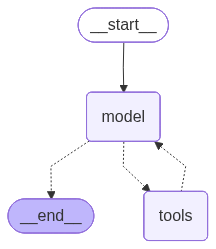

In [14]:
agent

### 核心要点：
- `create_agent()` 让这类标准 Agent 的构建变得极其简单
- Agent 自动处理了 推理 (Reasoning) → 行动 (Action) → 观察 (Observation) 的循环
- **LangGraph 1.0 特性**：它建立在 LangGraph 之上，天生具备生产级特性（持久化、流式传输、人机交互）

## 第 5 部分: 添加记忆 (Memory) & 状态 (State)

目前，每次 Agent 调用都是独立的。让我们添加 **Memory (记忆)**，以便 Agent 能够在多次交互中保持上下文。

LangGraph 使用 **Checkpointers (检查点保存器)** 来保存和恢复状态：

In [15]:
from langgraph.checkpoint.memory import MemorySaver
from langsmith import uuid7

# 创建一个内存检查点保存器 (在生产环境中，通常使用 PostgresSaver 等)
checkpointer = MemorySaver()

# 创建带有记忆的 Agent
agent_with_memory = create_agent(
    model=model,
    tools=[get_weather, search_movies],
    system_prompt="你是一个乐于助人的助手。",
    checkpointer=checkpointer # 传入 checkpointer 启用持久化
)

# 为此对话创建一个唯一的线程 ID (Thread ID)
config = {"configurable": {"thread_id": uuid7()}}

# 第一次交互
result1 = agent_with_memory.invoke(
    {"messages": [{"role": "user", "content": "我叫 FLY，我喜欢科幻电影。"}]},
    config=config
)

print("Response 1:", result1["messages"][-1].content)

# 第二次交互 - Agent 记得我们！
result2 = agent_with_memory.invoke(
    {"messages": [{"role": "user", "content": "我叫什么名字？我喜欢什么电影？"}]},
    config=config
)
print("\nResponse 2:", result2["messages"][-1].content)

Response 1: 你好 FLY！看起来当前系统没有找到符合条件的科幻电影推荐。你是否有兴趣尝试其他类型的电影？或者你有其他具体的科幻电影偏好，比如你喜欢那种情节或导演的作品？告诉我更多信息，我会尽力帮你找到满意的推荐！

Response 2: 你叫 FLY，并且你喜欢科幻电影。


### 理解状态 (State) & 线程 (Threads)

- **State (状态)**: Agent 的“记忆” —— 包含了消息历史和任何自定义数据。
- **Thread (线程)**: 由 `thread_id` 标识的一个对话会话。
- **Checkpointer**: 在每一步之后保存状态，实现了记忆功能和错误恢复能力。

每个线程都是独立的：

In [16]:
# 新的线程 - Agent 不会记得 FLY
new_config_with_new_thread_id = {"configurable": {"thread_id": uuid7()}}

result3 = agent_with_memory.invoke(
    {"messages": [{"role": "user", "content": "我叫什么名字？"}]},
    config=new_config_with_new_thread_id
)
print("New thread response:", result3["messages"][-1].content)

New thread response: 我不知道你的名字，你可以告诉我你喜欢我怎么称呼你吗？


### 核心要点：
- Checkpointers 实现了记忆
- Thread ID (线程 ID) 用于隔离不同的对话
- 状态会自动持久化 —— 无需手动管理状态保存！

## 第 6 部分: 流式传输 (Streaming) 提升用户体验

LLM 响应可能需要一些时间。**Streaming (流式传输)** 可以实时显示进度，极大地提升用户体验。

LangGraph 支持多种流式模式：

### 流式传输 Agent 步骤 (Streaming Steps)

In [17]:
# 使用 stream_mode="updates" 流式传输 Agent 的进度
print("Streaming agent steps:\n")

for chunk in agent.stream(
    {"messages": [{"role": "user", "content": "成都的天气怎么样？(北纬 30.66°，东经 104.07°) "}]},
    stream_mode="updates"
):
    # chunk 是这一步的状态更新
    for node_name, data in chunk.items():
        print(f"Step: {node_name}")
        if "messages" in data:
            message = data["messages"][-1]
            if hasattr(message, 'tool_calls') and message.tool_calls:
                print(f"   Tool call: {message.tool_calls[0]['name']}")
            elif hasattr(message, 'content'):
                content_preview = message.content[:100]
                print(f"   Content: {content_preview}...")
        print()

Streaming agent steps:

Step: model
   Tool call: get_weather

Step: tools
   Content: {"temperature_celsius": 7.7, "weather_code": 1}...

Step: model
   Content: 根据最新数据，成都当前气温约为7.7℃（约45.9℉）。天气代码为1，不过代码具体含义需要结合当地的气象标准来解读。总体来说，成都目前的天气较凉，出行时建议注意保暖。...



### 流式传输 LLM Token

为了获得类似 ChatGPT 的体验，我们可以流式传输生成的 Token：

In [18]:
# 使用 stream_mode="messages" 流式传输详细消息内容（包括 Token）
print("Streaming tokens:\n")

for token, metadata in agent.stream(
    {"messages": [{"role": "user", "content": "用一句话介绍一下 LangGraph。"}]},
    stream_mode="messages"
):
    # 仅打印来自模型节点的用于展示的内容
    if metadata.get('langgraph_node') == 'model':
        # 获取文本内容块
        for block in token.content_blocks:
            if block.get('type') == 'text' and block.get('text'):
                print(block['text'], end='', flush=True)

print("\n")  # 结尾换行

Streaming tokens:

LangGraph 是一个用于构建和可视化语言模型之间交互关系的轻量级工具，帮助用户探索和分析复杂的语言数据网络。



### 核心要点：
- `stream_mode="updates"` - 查看 Agent 的每一步操作（非常适合调试和展示思考过程）
- `stream_mode="messages"` - 流式传输 LLM Token（适合实现打字机效果）
- 不论是普通调用还是流式调用，写法几乎一致，无需额外配置！

## 📝 关键的迁移点

让我们回顾一下关键的迁移点：

#### ✅ 核心 API 变化

- [ ] **模型初始化**：`ChatOpenAI()` → `init_chat_model("openai:...")`
- [ ] **Agent 创建**：`create_react_agent()` → `create_agent()`
- [ ] **系统提示**：`messages_modifier=` → `system_prompt=`
- [ ] **导入路径**：`langgraph.prebuilt` → `langchain.agents`

#### ✅ 新特性采用

- [ ] **Middleware**：考虑使用中间件替代手动逻辑 [下次直播讲解]
- [ ] **Content Blocks**：使用 `.content_blocks` 统一访问消息内容
- [ ] **动态 Interrupt**：将静态 `interrupt_before` 改为 `interrupt()` [下次直播讲解]
- [ ] **Command 对象**：使用 `Command(resume=...)` 恢复中断 [下次直播讲解]

#### ✅ Checkpointer 更新

- [ ] 开发环境：使用 `MemorySaver()`
- [ ] 生产环境：考虑 `PostgresSaver`
- [ ] 确保所有需要 interrupt 的 Agent 都配置了 checkpointer 

#### ✅ 遗留功能迁移

如果使用以下功能，需要安装 `langchain-classic`：

- [ ] `langchain.chains` → `langchain_classic.chains`
- [ ] `langchain.retrievers` → `langchain_classic.retrievers`
- [ ] `langchain.hub` → `langchain_classic.hub`

---


## 🎉 恭喜！

你已经学习了使用 LangChain 1.x 和 LangGraph 1.x 构建 Agent 的核心概念：

 **Models** - 跨提供商的标准化接口  
 **Messages** - 对话的基石  
 **Tools** - 扩展 LLM 能力  
 **Agents** - 自动化的推理和行动循环  
 **Memory** - 跨交互保持上下文  
 **Streaming** - 实时用户体验  
 **LangGraph** - 驱动这一切的基石

### 资源：

- [LangChain 文档](https://python.langchain.com/docs/introduction/)
- [LangGraph 文档](https://langchain-ai.github.io/langgraph/)
- [LangSmith 调试](https://smith.langchain.com)
- [LangChain 学院](https://academy.langchain.com/)
  
---

**学习愉快！**

## 补充

### 测试DeepSeek模型

In [19]:
import os
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, SystemMessage

# ==========================================
# 配置区域
# ==========================================

# 1. 填入你的 DeepSeek API Key
DEEPSEEK_API_KEY = "sk-XXX" 

# 2. 设置环境变量（这是 LangChain 调用 OpenAI 兼容接口的标准方式）
# 虽然可以在函数中传参，但设置环境变量是最稳健的方法
os.environ["OPENAI_API_KEY"] = DEEPSEEK_API_KEY
os.environ["OPENAI_API_BASE"] = "https://api.deepseek.com"

def main():
    print("正在初始化 DeepSeek 模型...")

    # ==========================================
    # 核心代码：初始化模型
    # ==========================================
    model = init_chat_model(
        # 模型名称 (DeepSeek 官方名称: deepseek-chat 或 deepseek-coder)
        "deepseek-chat",
        
        # 提供商 (因为 DeepSeek 兼容 OpenAI 协议，所以这里必须填 openai)
        model_provider="openai",
        
        # 其他参数
        temperature=0.7,
        max_tokens=1024
        # 注意：因为上面设置了环境变量 OPENAI_API_BASE，这里不需要再传 base_url
    )

    # ==========================================
    # 场景 1：简单的单次问答
    # ==========================================
    print("\n--- 场景 1: 单次问答 ---")
    messages = [
        SystemMessage(content="你是一个精通Python的编程助手。"),
        HumanMessage(content="请用一句话解释什么是递归。")
    ]
    
    response = model.invoke(messages)
    print(f"回答: {response.content}")

    # ==========================================
    # 场景 2：流式输出 (像 ChatGPT 一样打字机效果)
    # ==========================================
    print("\n--- 场景 2: 流式输出 ---")
    query = "请写一个快速排序的 Python 代码示例，不要解释，只给代码。"
    
    print("正在生成代码: ", end="", flush=True)
    
    # 使用 .stream() 方法
    for chunk in model.stream(query):
        # 实时打印每个片段
        print(chunk.content, end="", flush=True)
    
    print("\n\n运行结束。")

if __name__ == "__main__":
    main()

正在初始化 DeepSeek 模型...

--- 场景 1: 单次问答 ---
回答: 递归是一种函数调用自身来解决问题的方法。

--- 场景 2: 流式输出 ---
正在生成代码: ```python
def quick_sort(arr):
    if len(arr) <= 1:
        return arr
    pivot = arr[len(arr) // 2]
    left = [x for x in arr if x < pivot]
    middle = [x for x in arr if x == pivot]
    right = [x for x in arr if x > pivot]
    return quick_sort(left) + middle + quick_sort(right)

# 原地排序版本
def quick_sort_inplace(arr, low=0, high=None):
    if high is None:
        high = len(arr) - 1
    if low < high:
        pi = partition(arr, low, high)
        quick_sort_inplace(arr, low, pi - 1)
        quick_sort_inplace(arr, pi + 1, high)

def partition(arr, low, high):
    pivot = arr[high]
    i = low - 1
    for j in range(low, high):
        if arr[j] <= pivot:
            i += 1
            arr[i], arr[j] = arr[j], arr[i]
    arr[i + 1], arr[high] = arr[high], arr[i + 1]
    return i + 1
```

运行结束。
